In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
color_discrete_map = {
    "ORF": "rgb(0, 158, 115)",
    "CRISPR": "rgb(213, 94, 0)",
}

In [3]:
orf_profiles_df = pd.read_parquet('../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet')
orf_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00117035,A01,JCP2022_905588,1.976969,2.478890,-0.027964,-0.219052,-0.387556,-0.408526,...,-3.660750,-3.651258,-3.679746,-3.644897,-3.663296,-3.716321,-3.636625,-3.645543,-3.727525,-3.679245
1,source_4,BR00117035,K16,JCP2022_904671,0.684687,0.466309,1.012648,1.663855,1.000000,1.678355,...,2.168216,2.330371,2.216136,2.194055,2.275831,2.223878,2.141747,2.128873,2.210318,2.163222
2,source_4,BR00117035,K15,JCP2022_910002,-0.712354,-0.223851,1.731486,0.288033,1.890591,0.316171,...,0.071314,0.096669,0.066603,0.058598,0.090844,0.078413,0.055205,0.052899,0.070066,0.026523
3,source_4,BR00117035,K14,JCP2022_915130,-0.748839,-0.735631,-1.233757,1.626520,-1.242626,1.721572,...,0.000000,0.035438,0.038872,0.072280,0.088573,0.059846,0.056558,0.043847,0.073777,0.033654
4,source_4,BR00117035,K13,JCP2022_907169,1.496820,1.681144,-0.732777,0.522362,-0.943322,0.331984,...,-0.516835,-0.599282,-0.606662,-0.613451,-0.645110,-0.646500,-0.589659,-0.642565,-0.653381,-0.626307


In [4]:
crispr_profiles_df = pd.read_parquet('../profiles/profiles_wellpos_cc_var_mad_outlier_crispr.parquet')
crispr_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_13,CP-CC9-R1-01,A02,JCP2022_800002,2.218619,2.431635,0.501694,1.198642,0.224633,0.844867,...,-0.831973,-0.825502,-0.889403,-0.903963,-0.883159,-0.895142,-0.891171,-0.866901,-0.905884,-0.872768
1,source_13,CP-CC9-R1-01,K20,JCP2022_804622,0.859567,0.653397,0.922855,0.118665,0.855094,-0.081124,...,0.609744,0.649153,0.534479,0.531941,0.522362,0.520395,0.525493,0.560134,0.529913,0.535044
2,source_13,CP-CC9-R1-01,K19,JCP2022_805152,-0.500199,-0.753580,-1.340301,1.341153,-1.202748,1.535985,...,-0.038382,0.033109,-0.058673,-0.048316,-0.044189,-0.057598,-0.068563,-0.049794,-0.063677,-0.079469
3,source_13,CP-CC9-R1-01,K18,JCP2022_802786,-2.561408,-2.725811,0.369015,0.812675,0.756190,1.300394,...,-0.002243,0.001495,0.001303,-0.005326,0.006601,0.000518,-0.004294,-0.006467,-0.000790,0.001377
4,source_13,CP-CC9-R1-01,K17,JCP2022_804790,-1.859622,-1.962506,0.333040,1.561787,0.604526,2.021736,...,-1.635407,-1.647799,-1.699584,-1.713905,-1.695603,-1.695303,-1.686945,-1.676755,-1.708273,-1.662995


In [5]:
selected_feature_names_df = pd.read_csv('output/selected_feature_names.csv')

In [6]:
present_features = []

for feature_name_1, feature_name_2 in selected_feature_names_df.values:
    if (
        feature_name_1 in orf_profiles_df.columns and feature_name_2 in orf_profiles_df.columns
    ):
        print(f"{feature_name_1} and {feature_name_2} is in the profiles")
        present_features.append(feature_name_1)
        present_features.append(feature_name_2)

orf_df = orf_profiles_df[present_features].copy()
orf_df = orf_df.loc[:,~orf_df.columns.duplicated()].copy().assign(Modality="ORF")


Nuclei_Texture_AngularSecondMoment_ER_10_01_256 and Nuclei_Texture_AngularSecondMoment_RNA_10_01_256 is in the profiles
Nuclei_Granularity_1_RNA and Cytoplasm_AreaShape_Solidity is in the profiles
Nuclei_AreaShape_Area and Cells_AreaShape_Area is in the profiles
Nuclei_Intensity_IntegratedIntensity_DNA and Cells_AreaShape_Area is in the profiles
Nuclei_Intensity_IntegratedIntensity_RNA and Cells_AreaShape_Area is in the profiles


In [7]:
present_features = []

for feature_name_1, feature_name_2 in selected_feature_names_df.values:
    if (
        feature_name_1 in crispr_profiles_df.columns and feature_name_2 in crispr_profiles_df.columns
    ):
        print(f"{feature_name_1} and {feature_name_2} is in the profiles")
        present_features.append(feature_name_1)
        present_features.append(feature_name_2)

crispr_df = crispr_profiles_df[present_features].copy()
crispr_df = crispr_df.loc[:,~crispr_df.columns.duplicated()].copy().assign(Modality="CRISPR")

Nuclei_Texture_AngularSecondMoment_ER_10_01_256 and Nuclei_Texture_AngularSecondMoment_RNA_10_01_256 is in the profiles
Nuclei_Granularity_1_RNA and Cytoplasm_AreaShape_Solidity is in the profiles
Nuclei_AreaShape_Area and Cells_AreaShape_Area is in the profiles
Nuclei_Intensity_IntegratedIntensity_DNA and Cells_AreaShape_Area is in the profiles
Nuclei_Intensity_IntegratedIntensity_RNA and Cells_AreaShape_Area is in the profiles


In [8]:
df = pd.concat([orf_df, crispr_df], ignore_index=True)

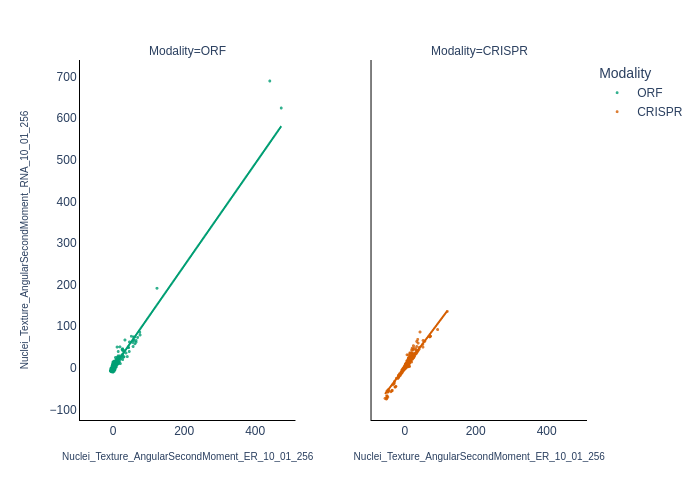

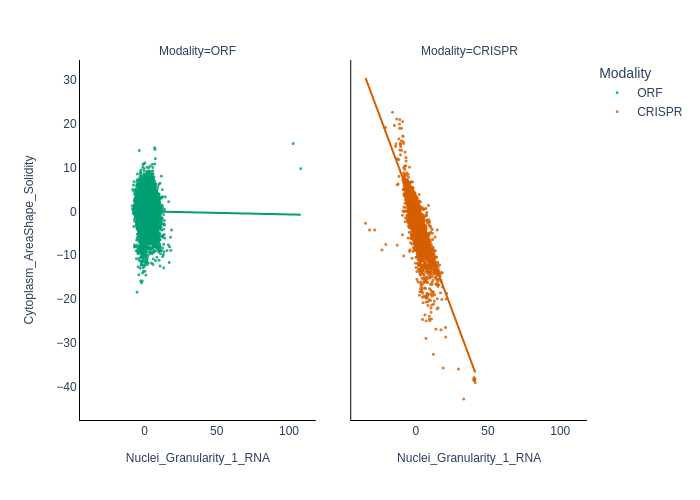

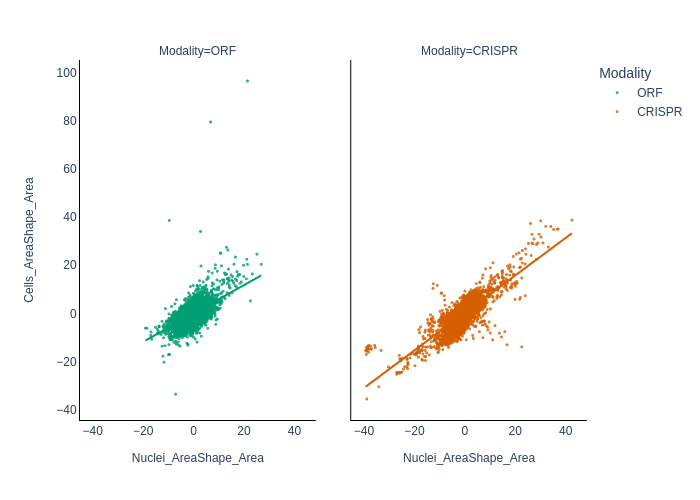

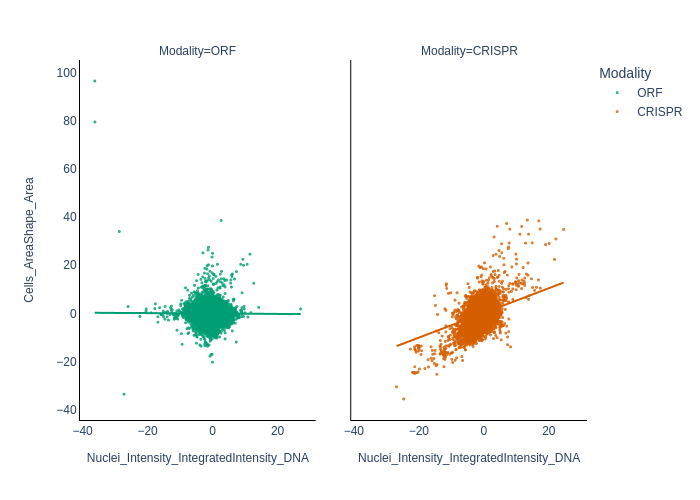

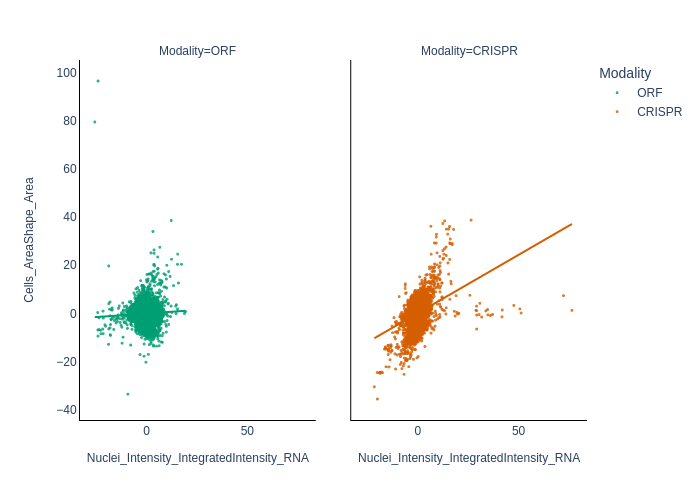

In [9]:
for feature_name_1, feature_name_2 in selected_feature_names_df.values:
    if len(feature_name_1) > 40:
        font_size = 10
        facet_col_spacing = 0.15
    else:
        font_size = 12
        facet_col_spacing = 0.07
    fig = px.scatter(
        df,
        x=feature_name_1,
        y=feature_name_2,
        facet_col="Modality",
        facet_col_spacing=facet_col_spacing,
        color="Modality",
        color_discrete_map=color_discrete_map,
        trendline="ols",
        opacity=0.8,
    ).update_layout(
        xaxis1=dict(title=feature_name_1, linecolor="#000000", title_font=dict(size=font_size)),
        xaxis2=dict(title=feature_name_1, linecolor="#000000", title_font=dict(size=font_size)),
        yaxis1=dict(title=feature_name_2, linecolor="#000000", title_font=dict(size=font_size)),
        yaxis2=dict(linecolor="#000000"),
        plot_bgcolor="rgba(0, 0, 0, 0)",
    ).update_traces(marker=dict(size=3))
    fig.show("png")
    fig.write_image(f"figures/{feature_name_1}_{feature_name_2}.png", width = 640, height = 480,scale=2)
    fig.write_image(f"figures/{feature_name_1}_{feature_name_2}.svg", width = 640, height = 480, scale=2)